<table style="background-color:#FFFFFF">   
  <tr>     
  <td><img src="https://upload.wikimedia.org/wikipedia/commons/9/95/Logo_EPFL_2019.svg" width="150x"/>
  </td>     
  <td>
  <h1> <b>CS-461: Foundation Models and Generative AI</b> </h1>
  Prof. Charlotte Bunne  
  </td>   
  </tr>
</table>

# 📚 Graded Assignment 1  
### CS-461: Foundation Models and Generative AI - Fall 2025  - Due: October 8, 23:59 CET

Welcome to the first graded assignment!
In this assignment, you will **implement and explore self-supervised learning** on a downsampled subset of the [ImageNet-1k dataset](https://www.image-net.org/), and evaluate how well your model generalizes **both in-distribution and out-of-distribution (OOD)**.  

---

## 🎯 Learning Objectives
By completing this assignment, you will learn to:
- Implement a custom **encoder** and **projection head** for images  
- Experiment with **data augmentations** for self-supervised learning  
- Train a model using a **self-supervised loss**  
- Evaluate learned representations with **k-NN** and **linear probes**  
- Assess **out-of-distribution (OOD) generalization** to unseen classes  
- Save, visualize, and submit results in a reproducible way  

---

## ⚡ Practical Notes
- **Dataset:**  
  - Training: 200 ImageNet classes, 500 images each (100k total)  
  - Validation: 200 ImageNet classes, 50 images each (10k total)  
  - **OOD dataset:** 200 unseen classes, 50 images each (10k total)  
- Use OOD only for **evaluation**, never for training.  
- Checkpoints and evaluation intervals are already set up — your main tasks are to fill in missing functions and customize the model.  
- Some helper utilities (e.g., dataset loaders, probes) are provided in `utils.py`.  

---

👉 **Deliverables:** You will submit:
- Your modified **`models.py`**  
- Trained weights in **`final_model.safetensors`**  
- A short **report.md** (max 500 words) — including **discussion of OOD results**  
- This completed notebook **CS461_Assignment1.ipynb**  

---

⚠️ **Important:** Don’t forget to fill in your **SCIPER number** and **full name** in Section 0, otherwise you will receive **0 points**.  

First, we import packages and set up the device. \
Feel free to add any additional packages you may need.

In [1]:
# Automatically reloads modules when you make changes (useful during development)
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import shutil

import numpy as np
import os
import json

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader
from safetensors.torch import save_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 🆔 0. SCIPER Number and Name  

⚠️ **IMPORTANT!** ⚠️  
You **must** fill in your **SCIPER number** and **full name** below.  

This is **required for automatic grading**.  
If you do **not** provide this information, you will receive **0️⃣ (zero)** for this assignment. 

In [3]:
SCIPER = 345625  
LAST_NAME = "Merville-Hipeau"
FIRST_NAME = "Mahlia"

## 1. Datasets & Utilities

- In the following, we will work with a subset of the ImageNet-1k dataset: color images downsampled to 64×64, covering 200 classes.
- The training set contains 500 images per class (100,000 images in total), and the validation set contains 50 images per class (10,000 images in total).
- The Out-Of-Distribution (OOD) datasets contain images from classes not present in the training set. It contains 50 images from 200 different classes (1,000 images in total).
- The purpose of these OOD datasets is to evaluate the generalization capabilities of the learned representations. You should not use it for training.
- During evalution, we will measure your model's performance on another OOD dataset (different from the one provided here), so make sure to not overfit on the provided OOD dataset.

<!-- Let's download/load it and define a default transformation turning a PIL Image into a `torch.tensor` -->
Make sure that you have access to the `/shared/CS461/cs461_assignment1_data/` folder. The folder structure should look like this:
```
cs461_assignment1_data/
└── train.npz
└── val.npz
└── ood.npz
```


Import dataset class and other utilities you developed in previous homeworks:

In [4]:
from utils import ImageDatasetNPZ, default_transform, seed_all
from utils import run_knn_probe, run_linear_probe, extract_features_and_labels

sklearnex not installed, using standard sklearn


For reproducibility, you can use the provided `seed_all` function to set the random seed for all relevant libraries (Python, NumPy, PyTorch).

In [5]:
seed_all(42)  # For reproducibility, you can use any integer here

You probably want to implement custom data augmentations for the self-supervised learning method you choose. \
Feel free to swap the `default_transform` defined below and create multiple instances of datasets with different transforms.

In [6]:
# data_dir = Path('/shared/CS461/cs461_assignment1_data/')
data_dir = Path('cs461_assignment1_data/')

You can split the provided OOD dataset into a training and validation set using the code below. \
You should not use the training split for actually training your models, but only for evaluation (e.g. kNN or linear probing).

In [7]:
rng = np.random.RandomState(42)
ds_ood = ImageDatasetNPZ(data_dir / 'ood.npz', transform=default_transform)
ood_val_ratio = 0.2
train_mask = rng.permutation(len(ds_ood)) >= int(len(ds_ood) * ood_val_ratio)
ds_oods_train = torch.utils.data.Subset(ds_ood, np.where(train_mask)[0])
ds_oods_val = torch.utils.data.Subset(ds_ood, np.where(~train_mask)[0])

In [8]:
batch_size = 128
num_workers = 4
pin_memory = True

checkpoints_dir = Path('checkpoints')
if not checkpoints_dir.exists():
    checkpoints_dir.mkdir(parents=True, exist_ok=False)

In [9]:
class SimCLRTransform:

    def __init__(self, size=32, s=0.5, blur_p=0.5): # s=1
        color_jitter = T.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
        k = 3 if size <= 32 else 5
        base = [
            T.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply([color_jitter], p=0.8),
            T.RandomGrayscale(p=0.2),
            # equalize, solarize, sobel
            T.RandomApply([T.GaussianBlur(kernel_size=k, sigma=(0.1, 2.0))], p=blur_p),
            T.ToTensor()
        ]
        self.train_transform = T.Compose(base)

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

def collate_fn(batch):
    xs1, xs2, ys = [], [], []
    for (x1, x2), y in batch:
        xs1.append(x1)
        xs2.append(x2)
        ys.append(y)
    return torch.stack(xs1), torch.stack(xs2), torch.tensor(ys)

In [10]:
simclr_transform = SimCLRTransform(size=32)

train_dataset = ImageDatasetNPZ(data_dir / 'train.npz', transform=simclr_transform)
train_dataset_noaugment = ImageDatasetNPZ(data_dir / 'train.npz', transform=default_transform)
val_dataset = ImageDatasetNPZ(data_dir / 'val.npz', transform=default_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True, collate_fn=collate_fn)

train_loader_noaugment = DataLoader(train_dataset_noaugment, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

oods_train_loader = DataLoader(ds_oods_train, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)
oods_val_loader = DataLoader(ds_oods_val, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

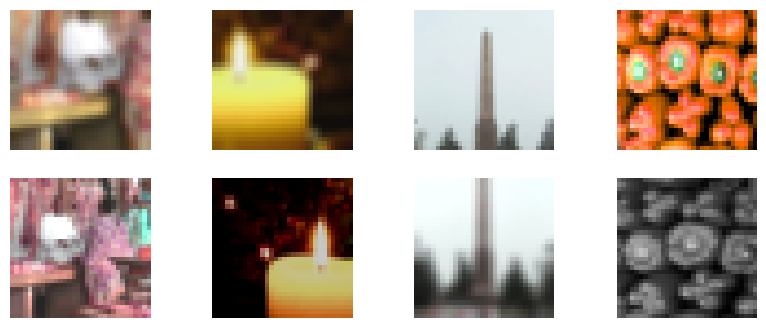

In [11]:
for x1, x2, y in train_loader:

    fig, axes = plt.subplots(2, 4, figsize=(10, 4))
    for i in range(4):
        img = x1[i].permute(1, 2, 0).cpu().numpy()  # (C,H,W) -> (H,W,C)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        img = x2[i].permute(1, 2, 0).cpu().numpy()  # (C,H,W) -> (H,W,C)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
    plt.show()
    
    break

# 2. Load Your Model

- Load your model from `models.py`.
- You will need to modify the `encoder` and `projection` modules, as the provided template implementation is only a placeholder.
- You SHOULD NOT change the `input_dim`, `input_channels`, and `feature_dim` parameters of the `ImageEncoder` class.
- You can use an existing architecture (e.g., ResNet, ViT) but you SHOULD NOT use any pre-trained weights.

In [12]:
from models import ImageEncoder

model = ImageEncoder().to(device)
model

ImageEncoder(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
       

## 3. Helpers for Training & Evaluation

We suggest you to implement the following helper functions to keep your training and evaluation loops clean and organized. \
- `training_step`: Performs a single training step (forward pass, loss computation, backward pass, optimizer step) and returns the loss value.
- `evaluation_step`: Evaluates the model on the validation dataset and returns the accuracy.

Depending on your specific requirements, you may also want to implement additional utility functions for tasks such as data loading, metric computation, and logging.

As you have seen from previous assignments, loss functions for self-supervised learning objectives can be quite complex. \
Feel free to implement any helper functions you may need to compute the loss.


In [13]:
def nt_xent(z1, z2, tau=0.1):
    """
    Computes NT-Xent loss.
    z1: (batch_size, feature_dim) tensor of normalized projection vectors
    z2: (batch_size, feature_dim) tensor of normalized projection vectors
    returns: loss (scalar)
    """
    
    B, d = z1.shape
    z = torch.cat([z1, z2], dim=0)              # (2B, d)
    sim = (z @ z.t()) / tau                     # (2B, 2B)
    mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
    sim.masked_fill_(mask, -1e9)
    targets = torch.arange(B, device=z.device)
    targets = torch.cat([targets + B, targets], dim=0)
    
    return F.cross_entropy(sim, targets)

In [14]:
def training_step(model, x1, x2, y_true, optimizer, device):
    
    model.train()
    x1, x2, y_true = x1.to(device), x2.to(device), y_true.to(device)
    
    # Forward pass to get projections
    _, z1 = model(x1)
    _, z2 = model(x2)

    # Loss computation
    loss = nt_xent(z1, z2)

    # Backward pass
    optimizer.zero_grad() 
    loss.backward()         
    optimizer.step()
    
    return loss


In [15]:
@torch.no_grad()
def evaluation_step(model, train_loader, val_loader, device="cuda"):
    model.eval()

    train_feats, train_labels = extract_features_and_labels(model, train_loader, normalize=True)
    val_feats, val_labels = extract_features_and_labels(model, val_loader, normalize=True)

    # Fit k-NN on train, evaluate on val
    knn_acc = run_knn_probe(train_feats.cpu().numpy(), train_labels.cpu().numpy(), val_feats.cpu().numpy(), val_labels.cpu().numpy()) * 100
    linear_acc = run_linear_probe(train_feats.cpu().numpy(), train_labels.cpu().numpy(), val_feats.cpu().numpy(), val_labels.cpu().numpy()) * 100
    
    return knn_acc, linear_acc

# 4. Optimizer Configuration

In [16]:
n_epochs = 50  # Adjust the number of epochs as needed
eval_interval = 5  # Evaluate the model every 'eval_interval' epochs
save_interval = 10  # Save the model every 'save_interval' epochs

In [17]:
# Feel free to adapt and add more arguments
lr = 0.3 * (batch_size / 256)
weight_decay = 1e-4
lr_step_size = 10
lr_gamma = 0.1
warmup_epochs = 10

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

# implement warm up for scheduler
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=1e-10, end_factor=1.0, total_iters=warmup_epochs
)

cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=n_epochs - warmup_epochs
)

lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)

# 5. Training Loop

Adapt your training configuration and implement the training loop. \
You probably want to save model checkpoints and evaluate the model on the validation set at regular intervals.

In [ ]:
training_data = {
    "train_losses": [],
    "knn_val_accuracies": [],
    "linear_val_accuracies": [],
    "knn_ood_accuracies": [],
    "linear_ood_accuracies": []
}

for epoch in tqdm(range(n_epochs), desc="Training Progress"):
    #  TRAINING
    running_loss = 0.0
    for x1, x2, y_true in train_loader:
        loss = training_step(model, x1, x2, y_true, optimizer, device)
        running_loss += loss
    # Saving loss    
    avg_loss = running_loss / len(train_loader)
    training_data["train_losses"].append(avg_loss.item())

    #  LEARNING RATE UPDATE
    if lr_scheduler is not None:
        lr_scheduler.step()

    #  EVALUATION (every few epochs)
    if (epoch + 1) % eval_interval == 0:
        knn_val_acc, linear_val_acc = evaluation_step(model, train_loader_noaugment, val_loader, device=device)
        knn_oods_acc, linear_oods_acc = evaluation_step(model, oods_train_loader, oods_val_loader, device=device)
        
        training_data["knn_val_accuracies"].append(knn_val_acc)
        training_data["linear_val_accuracies"].append(linear_val_acc)
        training_data["knn_ood_accuracies"].append(knn_oods_acc)
        training_data["linear_ood_accuracies"].append(linear_oods_acc)        
        
        print(f"Epoch [{epoch+1}/{n_epochs}] | "
              f"Train Loss: {avg_loss:.4f} | "
              f"Val k-NN Accuracy: {knn_val_acc:.2f}% | "
              f"Val Linear Accuracy: {linear_val_acc:.2f}% | "
              f"OOD k-NN Accuracy: {knn_oods_acc:.2f}% | "
              f"OOD Linear Accuracy: {linear_oods_acc:.2f}% | ")
              
    #  SAVE CHECKPOINTS
    if (epoch + 1) % save_interval == 0:
        ckpt_path = os.path.join(checkpoints_dir, f"model_epoch_{epoch+1}.safetensors")
        os.makedirs(checkpoints_dir, exist_ok=True)
        save_model(model, ckpt_path)
        print(f"Model checkpoint saved at {ckpt_path}")

#  SAVE FINAL METRICS
with open("training_data.json", "w") as f:
    json.dump(training_data, f)

#  SAVE FINAL MODEL
final_model_path = os.path.join(checkpoints_dir, "final_model.safetensors")
save_model(model, final_model_path)
print(f"Final model saved at {final_model_path}")

Training Progress:  10%|█         | 5/50 [13:35<2:52:18, 229.75s/it]

Epoch [5/50] | Train Loss: 1.3889 | Val k-NN Accuracy: 11.74% | Val Linear Accuracy: 18.79% | OOD k-NN Accuracy: 8.80% | OOD Linear Accuracy: 12.50% | 


Training Progress:  18%|█▊        | 9/50 [18:58<1:16:17, 111.64s/it]/home/mahlia/.conda/envs/ma3_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [10/50] | Train Loss: 0.9546 | Val k-NN Accuracy: 16.95% | Val Linear Accuracy: 23.96% | OOD k-NN Accuracy: 13.15% | OOD Linear Accuracy: 17.15% | 


Training Progress:  20%|██        | 10/50 [27:41<2:39:09, 238.74s/it]

Model checkpoint saved at checkpoints/model_epoch_10.safetensors


Training Progress:  30%|███       | 15/50 [42:50<2:02:21, 209.75s/it]

Epoch [15/50] | Train Loss: 0.7762 | Val k-NN Accuracy: 19.75% | Val Linear Accuracy: 26.46% | OOD k-NN Accuracy: 13.60% | OOD Linear Accuracy: 19.90% | 


Training Progress:  40%|████      | 20/50 [53:36<1:28:04, 176.15s/it]

Epoch [20/50] | Train Loss: 0.6866 | Val k-NN Accuracy: 21.82% | Val Linear Accuracy: 28.74% | OOD k-NN Accuracy: 15.35% | OOD Linear Accuracy: 21.10% | 
Model checkpoint saved at checkpoints/model_epoch_20.safetensors


Training Progress:  50%|█████     | 25/50 [1:04:15<1:11:03, 170.55s/it]

Epoch [25/50] | Train Loss: 0.6262 | Val k-NN Accuracy: 23.69% | Val Linear Accuracy: 29.98% | OOD k-NN Accuracy: 16.85% | OOD Linear Accuracy: 22.70% | 


Training Progress:  60%|██████    | 30/50 [1:14:51<56:32, 169.65s/it]  

Epoch [30/50] | Train Loss: 0.5818 | Val k-NN Accuracy: 24.45% | Val Linear Accuracy: 30.69% | OOD k-NN Accuracy: 17.65% | OOD Linear Accuracy: 22.80% | 
Model checkpoint saved at checkpoints/model_epoch_30.safetensors


Training Progress:  70%|███████   | 35/50 [1:24:55<40:00, 160.04s/it]

Epoch [35/50] | Train Loss: 0.5474 | Val k-NN Accuracy: 25.46% | Val Linear Accuracy: 31.67% | OOD k-NN Accuracy: 18.45% | OOD Linear Accuracy: 23.45% | 


Training Progress:  80%|████████  | 40/50 [1:35:07<26:46, 160.60s/it]

Epoch [40/50] | Train Loss: 0.5182 | Val k-NN Accuracy: 26.15% | Val Linear Accuracy: 32.27% | OOD k-NN Accuracy: 17.40% | OOD Linear Accuracy: 24.35% | 
Model checkpoint saved at checkpoints/model_epoch_40.safetensors


Training Progress:  90%|█████████ | 45/50 [1:45:26<13:35, 163.19s/it]

Epoch [45/50] | Train Loss: 0.5059 | Val k-NN Accuracy: 26.05% | Val Linear Accuracy: 32.73% | OOD k-NN Accuracy: 19.00% | OOD Linear Accuracy: 24.40% | 


Training Progress: 100%|██████████| 50/50 [1:56:15<00:00, 139.50s/it]

Epoch [50/50] | Train Loss: 0.5010 | Val k-NN Accuracy: 26.26% | Val Linear Accuracy: 32.80% | OOD k-NN Accuracy: 18.30% | OOD Linear Accuracy: 24.25% | 
Model checkpoint saved at checkpoints/model_epoch_50.safetensors


TypeError: Object of type Tensor is not JSON serializable

In [20]:
#  SAVE FINAL MODEL
final_model_path = os.path.join(checkpoints_dir, "final_model.safetensors")
save_model(model, final_model_path)
print(f"Final model saved at {final_model_path}")

Final model saved at checkpoints/final_model.safetensors


In [26]:
training_data["train_losses"] = [t.item() for t in training_data["train_losses"]]

In [27]:
#  SAVE FINAL METRICS
with open("training_data.json", "w") as f:
    json.dump(training_data, f)

# 6. Visualize Results

To better understand the performance of your trained model, visualize some results. \
You can visualize:
- Sample images from the validation set along with their predicted labels.
- Training and validation loss curves over epochs.

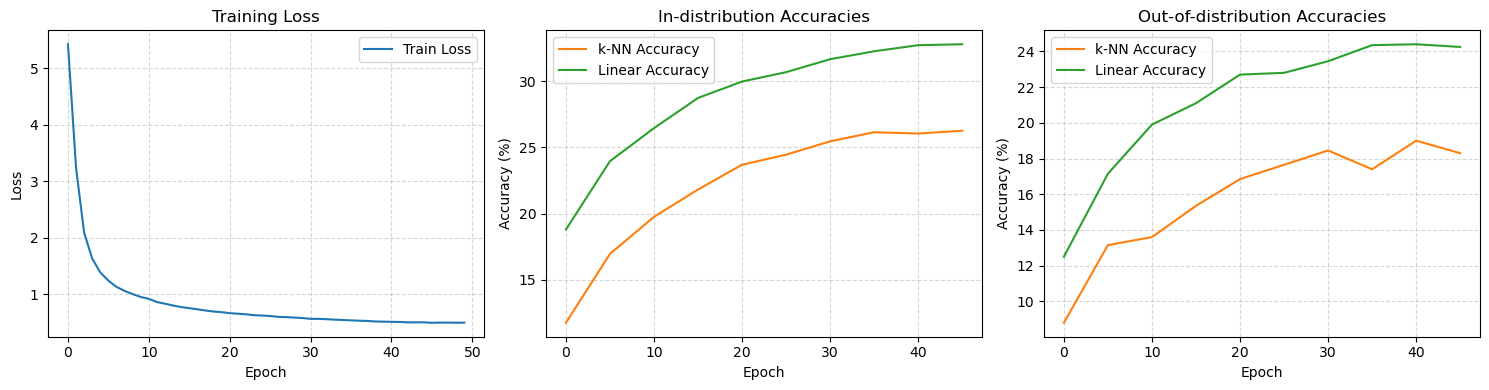

In [29]:
# --- Plot ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
epochs_val = [i for i in range(0,n_epochs, eval_interval)]

# Training loss
axes[0].plot(training_data["train_losses"], label="Train Loss", color="tab:blue")
axes[0].set_title("Training Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# Validation set evaluation
axes[1].plot(epochs_val, training_data["knn_val_accuracies"], label="k-NN Accuracy", color="tab:orange")
axes[1].plot(epochs_val, training_data["linear_val_accuracies"], label="Linear Accuracy", color="tab:green")
axes[1].set_title("In-distribution Accuracies")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.5)

# OOD set evaluation
axes[2].plot(epochs_val, training_data["knn_ood_accuracies"], label="k-NN Accuracy", color="tab:orange")
axes[2].plot(epochs_val, training_data["linear_ood_accuracies"], label="Linear Accuracy", color="tab:green")
axes[2].set_title("Out-of-distribution Accuracies")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Accuracy (%)")
axes[2].legend()
axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

# 7. Submission Instructions

You must submit the following files:
- `models.py`: Contains the implementation of your model architecture.
- `final_model.safetensors`: The trained model weights saved in the safetensors format.
- `report.md`: A brief report summarizing your approach, design choices, and results.
- `CS461_Assignment1.ipynb`: The Jupyter notebook containing your code and explanations. Make sure to save your progress before running the cell below.

You will submit your assignment under a single folder named `/home/cs461_assignment1_submission` containing the above files. \
Make sure to replace `<SCIPER>`, `<LAST_NAME>`, and `<FIRST_NAME>` with your actual SCIPER number, last name, and first name respectively. \
The following cell will help you move the files into the submission folder.

In [30]:
final_model_path = os.path.join(checkpoints_dir, "final_model.safetensors")
work_dir = Path('.')
output_dir = Path.home() / 'cs461_assignment1_submission'

if not output_dir.exists():
    output_dir.mkdir(parents=True, exist_ok=False)
    
shutil.copy(final_model_path, output_dir / 'final_model.safetensors')
shutil.copy(work_dir / 'models.py', output_dir / 'models.py')
shutil.copy(work_dir / 'CS461_Assignment1.ipynb', output_dir / 'CS461_Assignment1.ipynb')
shutil.copy(work_dir / 'report.md', output_dir / 'report.md')

PosixPath('/home/mahlia/cs461_assignment1_submission/report.md')

Check that all required files are present in the submission folder before running the cell below.

In [31]:
assert SCIPER is not None and LAST_NAME is not None and FIRST_NAME is not None, "Please set your SCIPER, LAST_NAME, and FIRST_NAME variables."

list_of_files = ['final_model.safetensors', 'models.py', 'CS461_Assignment1.ipynb', 'report.md']
files_found = all((output_dir / f).exists() for f in list_of_files)
assert files_found, f"One or more required files are missing in the submission folder: {list_of_files}"


You can test whether your submission folder is appropriately structured by using the `eval.py`:
```bash
python eval.py
```

In [32]:
### Uncomment the line below to run the evaluation script and check your model's performance

!python eval.py

sklearnex not installed, using standard sklearn
Dataset files not found in /shared/CS461/cs461_assignment1_data. Using random data for testing.
k-NN Accuracy: 0.15%
Linear Probe Accuracy: 0.15%
Evaluation completed.


---
🎉 **Congratulations!**  
You’ve completed Assignment 1. Good luck, and don’t forget to double-check your submission!